# Power Spectrum Analysis

## Configuration

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import pickle
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
import matplotlib as mpl
from deep_dss.helpers import *
import pymaster as nmt
import warnings

warnings.filterwarnings(action='once')

# Run on GPU.
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [192]:
# Defaults
plt.rcParams.update({
'lines.color':'black',
'font.family':'serif',
'font.weight':'normal',
'text.color':'black',
'text.usetex': True,
'axes.edgecolor':'black',
'axes.linewidth':1.0,
'axes.titlesize':'x-large',
'axes.labelsize':'x-large',
'axes.labelcolor':'black',
'xtick.labelsize':'x-large',
'xtick.minor.width':1.0,
'xtick.major.width':1.0,
'ytick.major.size':7,
'ytick.minor.size':4,
'ytick.major.pad':8,
'ytick.minor.pad':8,
'ytick.labelsize':'x-large',
'ytick.minor.width':1.0,
'ytick.major.width':1.0,
'legend.numpoints':1,
'legend.fontsize':'x-large',
'legend.shadow':False,
'legend.frameon':False})

In [32]:
# Config variables
config = "ck"
zscale = True
nside = 1024
order = 2
gaussian = False
free_bias = False
prior_low = 0.8
prior_high = 3.0

In [33]:
# Using covariance Q1 data
# data = split_count_and_lensing_maps_by_dataset("COVQ1", config=config, covariance=True, zscale=zscale)
data = split_count_and_lensing_maps_by_vals([201], config=config, covariance=True, zscale=zscale)

Here?


/Users/adiraju/opt/anaconda3/envs/deep_dss/lib/python3.8/site-packages/healpy/fitsfunc.py:368: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  warnings.warn(
/Users/adiraju/opt/anaconda3/envs/deep_dss/lib/python3.8/site-packages/healpy/fitsfunc.py:391: UserWarning: NSIDE = 1024
  warnings.warn("NSIDE = {0:d}".format(nside))
/Users/adiraju/opt/anaconda3/envs/deep_dss/lib/python3.8/site-packages/healpy/fitsfunc.py:400: UserWarning: ORDERING = NESTED in fits file
  warnings.warn("ORDERING = {0:s} in fits file".format(ordering))
/Users/adiraju/opt/anaconda3/envs/deep_dss/lib/python3.8/site-packages/healpy/fitsfunc.py:428: UserWarning: INDXSCHM = IMPLICIT
  warnings.warn("INDXSCHM = {0:s}".format(schm))


In [34]:
data

/Users/adiraju/opt/anaconda3/envs/deep_dss/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


{'x': array([[[ 0.        ,  0.30429895],
         [ 1.        , -0.65595962],
         [ 0.        , -0.79615904],
         ...,
         [ 0.        , -1.49107177],
         [ 0.        , -0.56381842],
         [ 0.        , -0.61929955]],
 
        [[ 0.        ,  0.11355799],
         [ 0.        , -1.55102042],
         [ 2.        ,  0.33895299],
         ...,
         [ 0.        , -0.44619274],
         [ 0.        ,  1.50813034],
         [ 0.        , -0.01360027]],
 
        [[ 2.        , -0.22484896],
         [ 0.        , -1.92205302],
         [ 0.        , -0.127974  ],
         ...,
         [ 0.        ,  0.5292191 ],
         [ 3.        ,  0.96369903],
         [ 0.        ,  1.87358235]],
 
        ...,
 
        [[ 1.        , -0.96500346],
         [ 0.        ,  0.13938627],
         [ 0.        ,  0.03983091],
         ...,
         [ 0.        , -0.63907131],
         [ 0.        ,  0.21478645],
         [ 0.        ,  0.71340601]],
 
        [[ 0.        ,  

In [35]:
data = data["x"]
data.shapem

(48, 262144, 2)

## Computing C_ells

In [142]:
bias = 1.54
density_arcmins = 0.04377 # Tracer density, galaxies/arcmin^2
density_steradians = density_arcmins * 3600 * (180/np.pi)**2

In [143]:
density_steradians

517278.36218405055

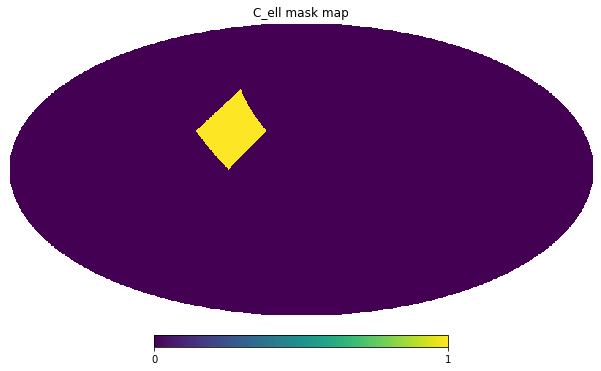

In [124]:
# Create mask for partial sky maps
mask_map = np.zeros(hp.nside2npix(nside))
mask_map[:(nside//order)**2] = 1
mask_map = hp.reorder(mask_map, n2r=True)
mask = nmt.mask_apodization(mask_map,
                            1., apotype="Smooth")
hp.mollview(mask_map, title="C_ell mask map")

/Users/adiraju/opt/anaconda3/envs/deep_dss/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/Users/adiraju/opt/anaconda3/envs/deep_dss/lib/python3.8/site-packages/healpy/projaxes.py:920: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  newcm.set_over(newcm(1.0))
/Users/adiraju/opt/anaconda3/envs/deep_dss/lib/python3.8/site-packages/healpy/projaxes.py:202: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 

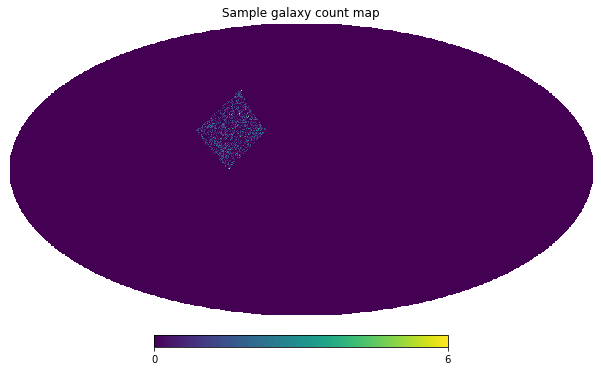

In [141]:
# Create full-sky version of counts map

count_map = np.zeros(hp.nside2npix(nside))
count_map[:(nside//order)**2] = np.copy(data[0,:,0])
count_map = hp.reorder(count_map, n2r=True)
hp.mollview(count_map, title="Sample galaxy count map")

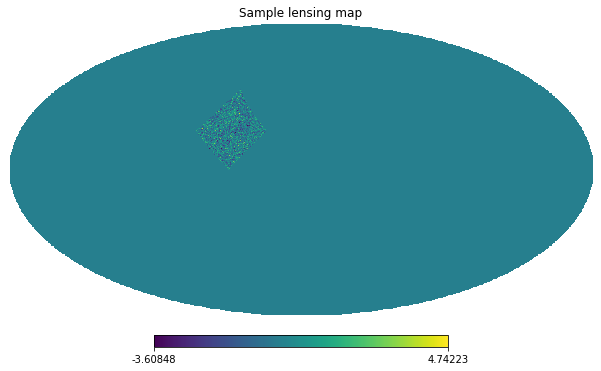

In [125]:
# Create full-sky version of lensing map
lensing_map = np.zeros(hp.nside2npix(nside))
lensing_map[:(nside//order)**2] = np.copy(data[0,:,1])
lensing_map = hp.reorder(lensing_map, n2r=True)
hp.mollview(lensing_map, title="Sample lensing map")

In [156]:
# Create Namaster fields from maps
count_field = nmt.NmtField(mask, [count_map])
lensing_field = nmt.NmtField(mask, [lensing_map])

In [190]:
# Initialize binning scheme with four ells per bandpower
binning = nmt.NmtBin.from_nside_linear(nside, 8)
ell_arr = binning.get_effective_ells()
print(ell_arr)

[   5.5   13.5   21.5   29.5   37.5   45.5   53.5   61.5   69.5   77.5
   85.5   93.5  101.5  109.5  117.5  125.5  133.5  141.5  149.5  157.5
  165.5  173.5  181.5  189.5  197.5  205.5  213.5  221.5  229.5  237.5
  245.5  253.5  261.5  269.5  277.5  285.5  293.5  301.5  309.5  317.5
  325.5  333.5  341.5  349.5  357.5  365.5  373.5  381.5  389.5  397.5
  405.5  413.5  421.5  429.5  437.5  445.5  453.5  461.5  469.5  477.5
  485.5  493.5  501.5  509.5  517.5  525.5  533.5  541.5  549.5  557.5
  565.5  573.5  581.5  589.5  597.5  605.5  613.5  621.5  629.5  637.5
  645.5  653.5  661.5  669.5  677.5  685.5  693.5  701.5  709.5  717.5
  725.5  733.5  741.5  749.5  757.5  765.5  773.5  781.5  789.5  797.5
  805.5  813.5  821.5  829.5  837.5  845.5  853.5  861.5  869.5  877.5
  885.5  893.5  901.5  909.5  917.5  925.5  933.5  941.5  949.5  957.5
  965.5  973.5  981.5  989.5  997.5 1005.5 1013.5 1021.5 1029.5 1037.5
 1045.5 1053.5 1061.5 1069.5 1077.5 1085.5 1093.5 1101.5 1109.5 1117.5
 1125.

/Users/adiraju/opt/anaconda3/envs/deep_dss/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [191]:
# Compute MASTER estimator
cl_gg = nmt.compute_full_master(count_field, count_field, binning)
cl_gk = nmt.compute_full_master(count_field, lensing_field, binning)
cl_kk = nmt.compute_full_master(lensing_field, lensing_field, binning)

In [158]:
cl_gg

array([[-3.89666735e+02,  7.69853457e+02, -1.13064412e+03,
         1.46321951e+03, -1.75967535e+03,  2.01329907e+03,
        -2.21878388e+03,  2.37238621e+03, -2.47201982e+03,
         2.51728843e+03, -2.50945448e+03,  2.45134951e+03,
        -2.34722586e+03,  2.20256110e+03, -2.02382227e+03,
         1.81820091e+03, -1.59332961e+03,  1.35699310e+03,
        -1.11684470e+03,  8.80140509e+02, -6.53500283e+02,
         4.42705035e+02, -2.52537038e+02,  8.66681893e+01,
         5.24017070e+01, -1.63355741e+02,  2.46022367e+02,
        -3.01292931e+02,  3.31000849e+02, -3.37769110e+02,
         3.24835053e+02, -2.95861031e+02,  2.54740676e+02,
        -2.05409279e+02,  1.51667161e+02, -9.70228321e+01,
         4.45623227e+01,  3.15131054e+00, -4.41452015e+01,
         7.70700741e+01, -1.01200235e+02,  1.16402964e+02,
        -1.23080645e+02,  1.22090909e+02, -1.14650147e+02,
         1.02226946e+02, -8.64314245e+01,  6.89069188e+01,
        -5.12292882e+01,  3.48190143e+01, -2.08695899e+0

In [159]:
cl_gk

array([[-6.11749521e+01,  1.20076016e+02, -1.74494728e+02,
         2.22434257e+02, -2.62180261e+02,  2.92371376e+02,
        -3.12053284e+02,  3.20718885e+02, -3.18319954e+02,
         3.05261566e+02, -2.82374893e+02,  2.50870405e+02,
        -2.12273653e+02,  1.68349168e+02, -1.21013994e+02,
         7.22468437e+01, -2.39965695e+01, -2.19044311e+01,
         6.38192847e+01, -1.00372504e+02,  1.30501455e+02,
        -1.53489695e+02,  1.68982492e+02, -1.76982775e+02,
         1.77829753e+02, -1.72160853e+02,  1.60860484e+02,
        -1.44998052e+02,  1.25759659e+02, -1.04376867e+02,
         8.20571500e+01, -5.99193775e+01,  3.89382248e+01,
        -1.98997525e+01,  3.37099723e+00,  1.03159389e+01,
        -2.10643493e+01,  2.89990113e+01, -3.44388459e+01,
         3.78587270e+01, -3.98429383e+01,  4.10337644e+01,
        -4.20782992e+01,  4.35773574e+01, -4.60392790e+01,
         4.98419333e+01, -5.52048060e+01,  6.21730892e+01,
        -7.06142868e+01,  8.02275884e+01, -9.05648959e+0

In [160]:
cl_kk

array([[-5.52732107e+02,  1.08809659e+03, -1.58943499e+03,
         2.04147787e+03, -2.43095772e+03,  2.74713192e+03,
        -2.98218804e+03,  3.13152159e+03, -3.19386244e+03,
         3.17125798e+03, -3.06890623e+03,  2.89485547e+03,
        -2.65958068e+03,  2.37546412e+03, -2.05620049e+03,
         1.71616155e+03, -1.36974628e+03,  1.03075219e+03,
        -7.11791804e+02,  4.23787335e+02, -1.75559770e+02,
        -2.64656630e+01,  1.78430125e+02, -2.79080493e+02,
         3.29682374e+02, -3.33812692e+02,  2.97048548e+02,
        -2.26569891e+02,  1.30700706e+02, -1.84130240e+01,
        -1.01177434e+02,  2.19299143e+02, -3.27969590e+02,
         4.20376826e+02, -4.91178008e+02,  5.36703929e+02,
        -5.55060767e+02,  5.46129031e+02, -5.11462555e+02,
         4.54098772e+02, -3.78293269e+02,  2.89198007e+02,
        -1.92502792e+02,  9.40633614e+01,  4.62989322e-01,
        -8.59519974e+01,  1.58099782e+02, -2.13646851e+02,
         2.50528765e+02, -2.67946353e+02,  2.66355201e+0

Text(0.5, 1.0, 'MASTER estimate for galaxy auto-correlation')

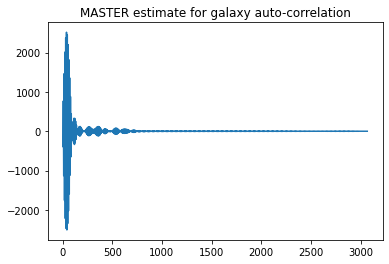

In [161]:
plt.plot(ell_arr, cl_gg[0])
plt.title("MASTER estimate for galaxy auto-correlation")

/Users/adiraju/opt/anaconda3/envs/deep_dss/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Text(0.5, 1.0, 'MASTER estimate for galaxy-lensing cross-correlation')

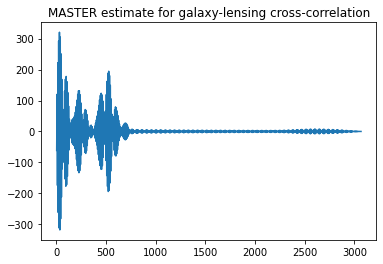

In [164]:
plt.plot(ell_arr, cl_gk[0])
plt.title("MASTER estimate for galaxy-lensing cross-correlation")

/Users/adiraju/opt/anaconda3/envs/deep_dss/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Text(0.5, 1.0, 'MASTER estimate for lensing auto-correlation')

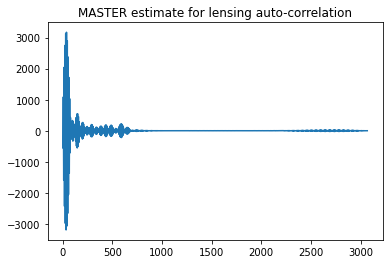

In [189]:
plt.plot(ell_arr, cl_kk[0])
plt.title("MASTER estimate for lensing auto-correlation")

In [94]:
c_ell_path = "../data/flaskv3/input/dss-0.85/dss-0.85-Cl-"

/Users/adiraju/opt/anaconda3/envs/deep_dss/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [166]:
cl_gg_trough = pd.read_csv(c_ell_path+"f1z1f1z1.dat", sep=' ', header=None)
cl_gg_trough.columns = ['L', 'CL']
cl_gg_trough.index = np.arange(10000)

/Users/adiraju/opt/anaconda3/envs/deep_dss/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [167]:
cl_gg_trough['CL'] = cl_gg_trough['CL']*bias**2 + 1/density_steradians

In [168]:
cl_gg_trough

,L,CL
0,0.0,0.000002
1,1.0,0.000002
2,2.0,0.000021
3,3.0,0.000035
4,4.0,0.000045
...,...,...
9995,9995.0,0.000002
9996,9996.0,0.000002
9997,9997.0,0.000002
9998,9998.0,0.000002


In [169]:
cl_gk_trough = pd.read_csv(c_ell_path+"f1z1f2z1.dat", sep=' ', header=None)
cl_gk_trough.columns = ['L', 'CL']
cl_gk_trough.index = np.arange(10000)

/Users/adiraju/opt/anaconda3/envs/deep_dss/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [170]:
cl_gk_trough['CL'] = bias*cl_gk_trough['CL']

In [171]:
cl_gk_trough

,L,CL
0,0.0,0.000000e+00
1,1.0,0.000000e+00
2,2.0,3.073930e-07
3,3.0,5.163153e-07
4,4.0,6.719013e-07
...,...,...
9995,9995.0,2.910872e-10
9996,9996.0,2.910246e-10
9997,9997.0,2.909620e-10
9998,9998.0,2.908994e-10


In [172]:
cl_k1k1_trough = pd.read_csv(c_ell_path+"f2z1f2z1.dat", sep=' ', header=None)
cl_k1k1_trough.columns = ['L', 'CL']
cl_k1k1_trough.index = np.arange(10000)

cl_k2k2_trough = pd.read_csv(c_ell_path+"f2z2f2z2.dat", sep=' ', header=None)
cl_k2k2_trough.columns = ['L', 'CL']
cl_k2k2_trough.index = np.arange(10000)

cl_kk_trough = pd.read_csv(c_ell_path+"f1z1f2z1.dat", sep=' ', header=None)
cl_kk_trough.columns = ['L', 'CL']
cl_kk_trough.index = np.arange(10000)
cl_kk_trough['CL'] = cl_k1k1_trough['CL'] + cl_k2k2_trough['CL']

/Users/adiraju/opt/anaconda3/envs/deep_dss/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [173]:
cl_kk_trough

,L,CL
0,0.0,0.000000e+00
1,1.0,0.000000e+00
2,2.0,1.951003e-08
3,3.0,2.813902e-08
4,4.0,3.265473e-08
...,...,...
9995,9995.0,8.427463e-12
9996,9996.0,8.425706e-12
9997,9997.0,8.423950e-12
9998,9998.0,8.422195e-12


/Users/adiraju/opt/anaconda3/envs/deep_dss/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Text(0.5, 1.0, 'Trough_lenser galaxy auto-correlation')

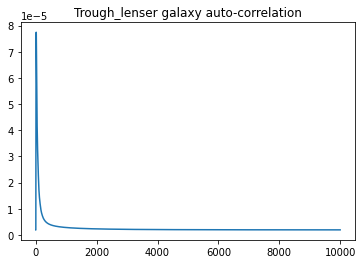

In [174]:
plt.plot(cl_gg_trough['L'], cl_gg_trough['CL'])
plt.title("Trough_lenser galaxy auto-correlation")

/Users/adiraju/opt/anaconda3/envs/deep_dss/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Text(0.5, 1.0, 'Trough_lenser galaxy-lensing cross-correlation')

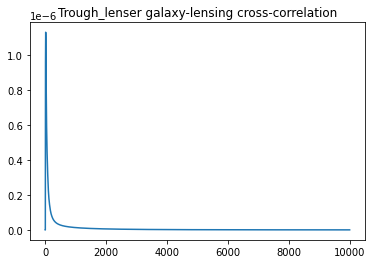

In [175]:
plt.plot(cl_gk_trough['L'], cl_gk_trough['CL'])
plt.title("Trough_lenser galaxy-lensing cross-correlation")

/Users/adiraju/opt/anaconda3/envs/deep_dss/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Text(0.5, 1.0, 'Trough_lenser lensing auto-correlation')

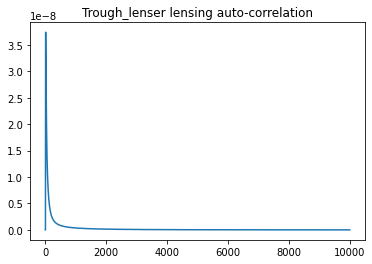

In [176]:
plt.plot(cl_kk_trough['L'], cl_kk_trough['CL'])
plt.title("Trough_lenser lensing auto-correlation")

/Users/adiraju/opt/anaconda3/envs/deep_dss/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Text(0.5, 1.0, 'Predicted vs. measured galaxy auto-correlations')

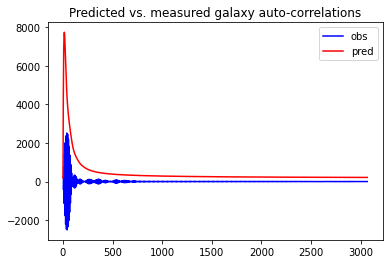

In [188]:
plt.plot(ell_arr, cl_gg[0], 'b-', label='obs')
plt.plot(cl_gg_trough['L'][:int(np.ceil(np.max(ell_arr)))], 1e8*cl_gg_trough['CL'][:int(np.ceil(np.max(ell_arr)))],
         'r-', label='pred')
plt.legend()
plt.title("Predicted vs. measured galaxy auto-correlations")

/Users/adiraju/opt/anaconda3/envs/deep_dss/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Text(0.5, 1.0, 'Predicted vs. measured galaxy-lensing cross-correlations')

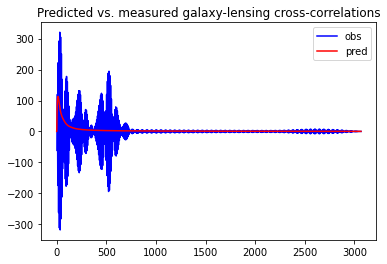

In [187]:
plt.plot(ell_arr, cl_gk[0], 'b-', label='obs')
plt.plot(cl_gk_trough['L'][:int(np.ceil(np.max(ell_arr)))], 1e8*cl_gk_trough['CL'][:int(np.ceil(np.max(ell_arr)))],
         'r-', label='pred')
plt.legend()
plt.title("Predicted vs. measured galaxy-lensing cross-correlations")

/Users/adiraju/opt/anaconda3/envs/deep_dss/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Text(0.5, 1.0, 'Predicted vs. measured lensing auto-correlations')

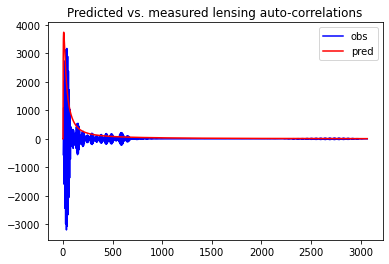

In [186]:
plt.plot(ell_arr, cl_kk[0], 'b-', label='obs')
plt.plot(cl_kk_trough['L'][:int(np.ceil(np.max(ell_arr)))], 1e11*cl_kk_trough['CL'][:int(np.ceil(np.max(ell_arr)))],
         'r-', label='pred')
plt.legend()
plt.title("Predicted vs. measured lensing auto-correlations")